In [1]:
# Data Loading
FILE = "Crop_Classification_Chugay.xlsx"

# Selected Features
COLUMNS_X = [
  "stage",
  "gauss_amplitude",	"gauss_mean",	"gauss_sd",
  "mean_blue_at_peak",	"mean_green_at_peak",	"mean_red_at_peak",
  "mean_red_edge_1_at_peak",	"mean_red_edge_2_at_peak",	"mean_red_edge_3_at_peak",
  "mean_nir_at_peak",	"mean_red_edge_4_at_peak",
  "mean_swir_1_at_peak",	"mean_swir_2_at_peak",
  "mean_slavi_at_peak",	"mean_cig_at_peak",
  "mean_ndmi_at_peak",	"mean_nbr2_at_peak",
  "mean_bsi_at_peak",
  "dtw_cluster",	"dtw_fcluster",
  "cluster_1",	"cluster_2",	"cluster_3",
  "cluster_4",	"cluster_5",	"cluster_6",
  "cluster_7"
]
COLUMNS_Y = ["crop_en_b"]
col_y=0

OUT_DIR="output"
n_neighbors=8
random_state=0

In [2]:
!git clone https://github.com/trucomanx/PythonMlTools.git

Cloning into 'PythonMlTools'...
remote: Enumerating objects: 822, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 822 (delta 75), reused 88 (delta 31), pack-reused 649 (from 1)
Receiving objects: 100% (822/822), 180.44 KiB | 4.75 MiB/s, done.
Resolving deltas: 100% (410/410), done.


In [3]:
dropbox_url = "https://www.dropbox.com/scl/fi/4a4n1enozrk8eh735wst9/Crop_Classification_Chugay_V1.xlsx?rlkey=1yujtaokwdmvix7lg76zvqkxs&st=5qfi4tt1&dl=0"

# Ensure that the URL is a direct download link
download_url = dropbox_url.replace('dl=0', 'dl=1')

# Donwloading the excel file
!wget -O "{FILE}" "{download_url}"


--2025-12-11 04:13:53--  https://www.dropbox.com/scl/fi/4a4n1enozrk8eh735wst9/Crop_Classification_Chugay_V1.xlsx?rlkey=1yujtaokwdmvix7lg76zvqkxs&st=5qfi4tt1&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc00229018607096b70a64a79adf.dl.dropboxusercontent.com/cd/0/inline/C230dHlAP1wExpTpP7f_gCFLUL6etaN_HrOQQcLwyKk38x3UUHgl0Vpkr8M51Xi1pdLo5RJT1ODsepQ2qCqZ33BEgzYjYtUwy3aCZVRDZsZvaWP8ISZwhka2FomNmzXu6sg/file?dl=1# [following]
--2025-12-11 04:13:54--  https://uc00229018607096b70a64a79adf.dl.dropboxusercontent.com/cd/0/inline/C230dHlAP1wExpTpP7f_gCFLUL6etaN_HrOQQcLwyKk38x3UUHgl0Vpkr8M51Xi1pdLo5RJT1ODsepQ2qCqZ33BEgzYjYtUwy3aCZVRDZsZvaWP8ISZwhka2FomNmzXu6sg/file?dl=1
Resolving uc00229018607096b70a64a79adf.dl.dropboxusercontent.com (uc00229018607096b70a64a79adf.dl.dropboxusercontent.com)... 162.125.5.15,

In [4]:
import pandas as pd
import numpy as np

df = pd.read_excel(FILE)
df["stage"] = df["stage"].astype("category").cat.codes

X = df[COLUMNS_X].to_numpy()
Y = df[COLUMNS_Y].to_numpy()

In [5]:
print("Matriz X:", X.shape)
print("Matriz Y:", Y.shape)

Matriz X: (453, 28)
Matriz Y: (453, 1)


In [6]:
# Mutual Information (Final Features)

def entropy(y):
    p = np.bincount(y) / len(y)
    p = p[p > 0]
    return -np.sum(p * np.log(p))

In [7]:
import numpy as np
import os
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y_int = le.fit_transform(Y[:,col_y].ravel())

# Compute Mutual Information
mi = mutual_info_classif(X, y_int, discrete_features=False, n_neighbors=n_neighbors, random_state=random_state)

# Y entropy
H_y = entropy(y_int)

# Generate table
df_mi = pd.DataFrame({"Coluna": COLUMNS_X,"MI": mi, "MI/Hy(%)": 100.0*mi/H_y})

# Save to file
os.makedirs(OUT_DIR, exist_ok=True)
df_mi.to_csv(os.path.join(OUT_DIR,"informacao_mutua_x_vs_y.csv"), index=False)


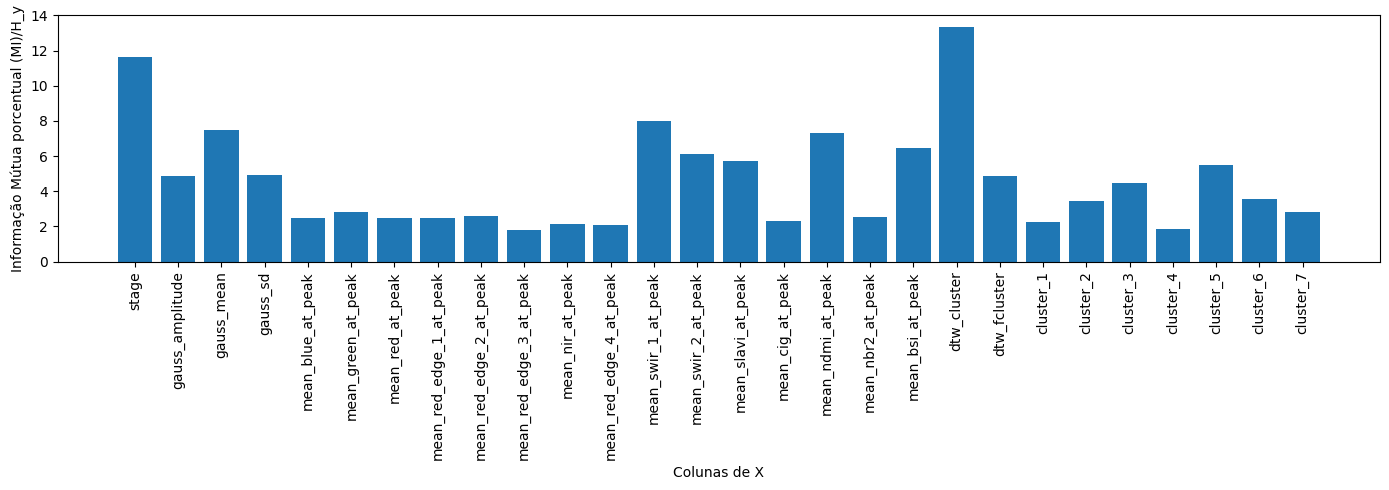

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.bar(COLUMNS_X, 100.0*mi/H_y)
plt.xticks(rotation=90)
plt.ylabel("Informação Mútua porcentual (MI)/H_y")
plt.xlabel("Colunas de X")
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import itertools

# X as shape (N, 28)

n_features = X.shape[1]
mi_matrix = np.zeros((n_features, n_features))
H_joint = np.zeros((n_features, n_features))

# Computing MI(i,j)
for i, j in itertools.product(range(n_features), repeat=2):
    mi_matrix[i, j] = mutual_info_regression(
        X[:, [i]],      # feature i
        X[:, j],        # feature j as "target"
        n_neighbors=n_neighbors,
        random_state=random_state
    )[0]

df_mi_xx = pd.DataFrame(mi_matrix, index=COLUMNS_X, columns=COLUMNS_X)

# Save to File
os.makedirs(OUT_DIR, exist_ok=True)
df_mi_xx.to_csv(os.path.join(OUT_DIR,"informacao_mutua_x_vs_x.csv"), index=False)

In [10]:
diag = np.diag(mi_matrix)

mi_matrix_normalized = 100.0*mi_matrix / diag[:, None]

df_pi_xx = pd.DataFrame(mi_matrix_normalized, index=COLUMNS_X, columns=COLUMNS_X)

# Save to File
os.makedirs(OUT_DIR, exist_ok=True)
df_pi_xx.to_csv(os.path.join(OUT_DIR,"informacao_mutua_porcentual_x_vs_x.csv"), index=False)

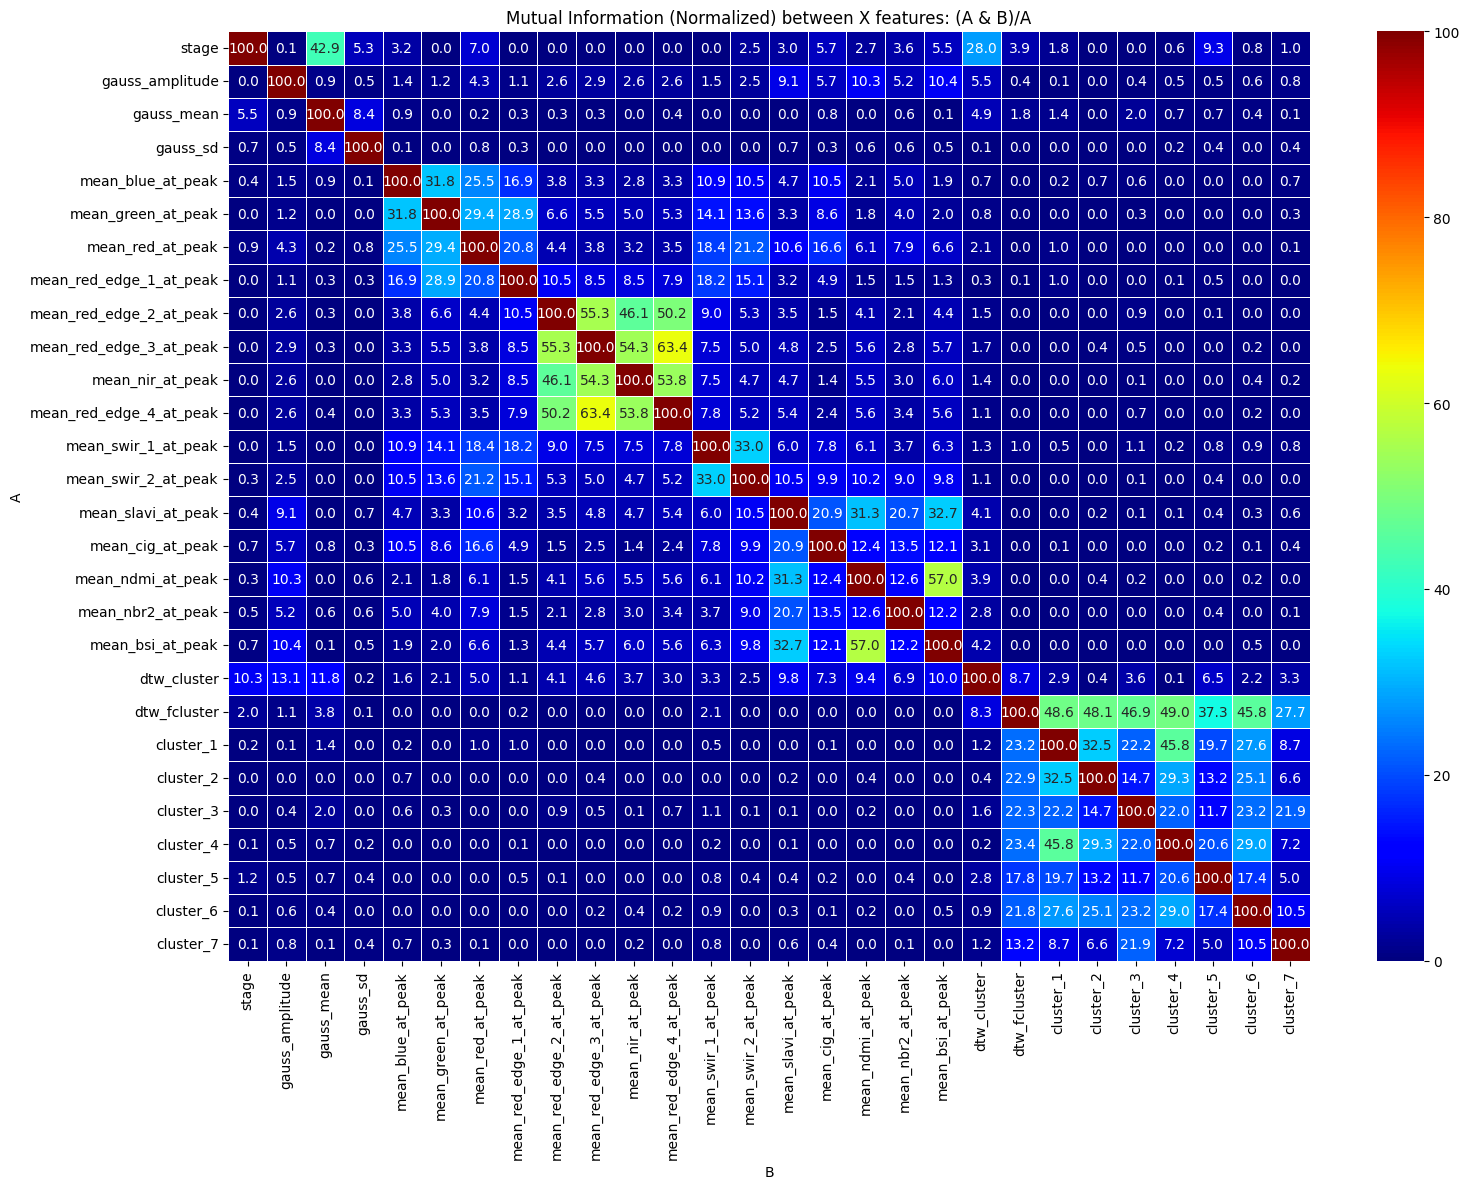

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap(df_pi_xx, annot=True, cmap='jet', fmt=".1f", linewidths=.5)
plt.title('Mutual Information (Normalized) between X features: (A & B)/A')
plt.xlabel('B')
plt.ylabel('A')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# Training SVM Classification with KG and K-fold
from collections import Counter

hist = dict(Counter(Y[:,col_y]))

In [13]:
hist

{'barley': 68,
 'oats': 38,
 'fallow': 48,
 'potato': 182,
 'pasture': 30,
 'beans': 49,
 'lupin': 38}

In [14]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y_int = le.fit_transform(Y[:,col_y].ravel())

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [16]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled,
                                                            y_int,
                                                            test_size=0.3,
                                                            random_state=random_state,
                                                            stratify=y_int)

In [17]:
import sys
sys.path.append('PythonMlTools/src')
from PythonMlTools.Classification.SvcGaussianKfold import FuncSVCKfoldBestGaussian

epsilon_list=np.linspace(0.1, 8, 96)
gamma_list=np.linspace(0.001, 0.12, 48)
ksvc_opt, epsilon_opt, gamma_opt, score_val_opt, SCORE_EG=FuncSVCKfoldBestGaussian(epsilon_list,
                                                                                   gamma_list,
                                                                                   X_train_val,
                                                                                   y_train_val,
                                                                                   K=5)

  0%|          | 0/96 [00:00<?, ?it/s]


Acc. train+val: 0.6971608832807571


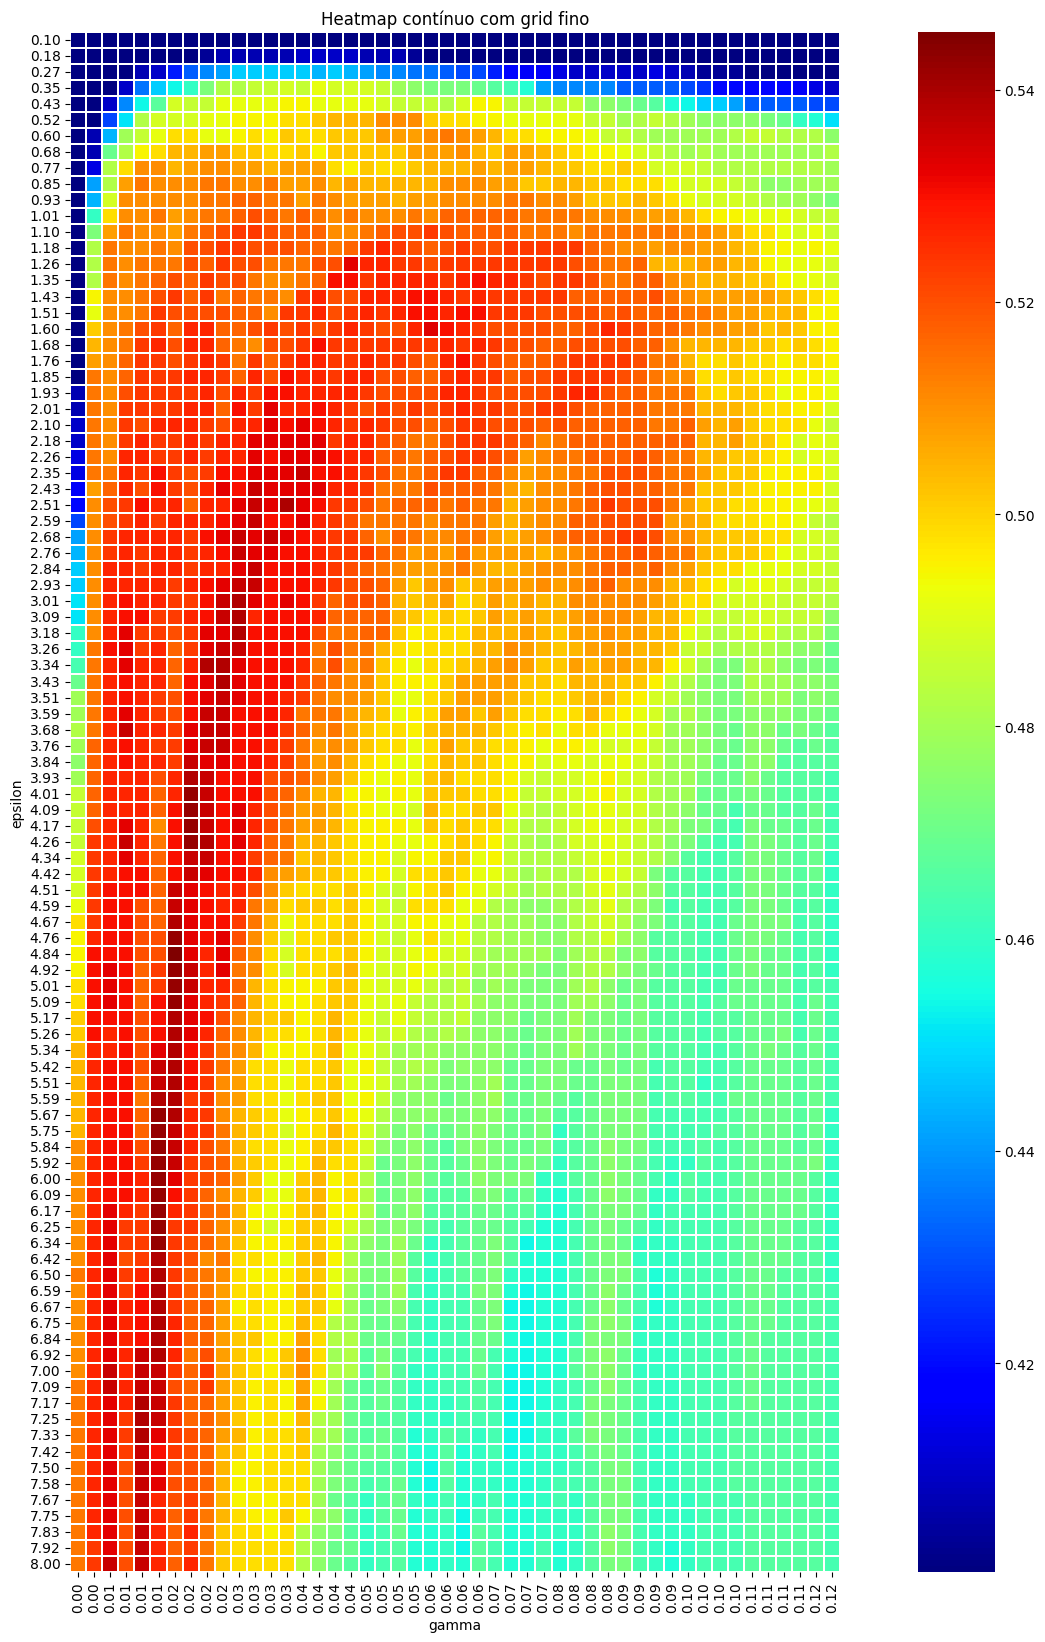

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

gamma_labels = [f"{v:.2f}" for v in gamma_list]
epsilon_labels = [f"{v:.2f}" for v in epsilon_list]

plt.figure(figsize=(20, 20))

sns.heatmap(
    SCORE_EG,
    xticklabels=gamma_labels,
    yticklabels=epsilon_labels,
    cmap='jet',
    cbar=True,
    square=True,
    linewidths=0.2,   # grid thickness
    linecolor='white' # grid color
)
plt.xlabel('gamma')
plt.ylabel('epsilon')
plt.title("Heatmap contínuo com grid fino")
plt.show()


In [19]:
from sklearn.metrics import classification_report
import os

print("Acc. test:",ksvc_opt.score(X_test, y_test))
print({i: c for i, c in enumerate(le.classes_)})

y_pred = ksvc_opt.predict(X_test)

res=classification_report(y_test, y_pred, digits=4,target_names=le.classes_)

os.makedirs(OUT_DIR, exist_ok=True)
with open(os.path.join(OUT_DIR,"test_classification_report.txt"), "w") as f:
    f.write(res)

print(res)

Acc. test: 0.5514705882352942
{0: 'barley', 1: 'beans', 2: 'fallow', 3: 'lupin', 4: 'oats', 5: 'pasture', 6: 'potato'}
              precision    recall  f1-score   support

      barley     0.6957    0.7619    0.7273        21
       beans     0.2353    0.2667    0.2500        15
      fallow     0.5000    0.1429    0.2222        14
       lupin     0.2000    0.0909    0.1250        11
        oats     0.0000    0.0000    0.0000        11
     pasture     0.3333    0.1111    0.1667         9
      potato     0.6296    0.9273    0.7500        55

    accuracy                         0.5515       136
   macro avg     0.3706    0.3287    0.3202       136
weighted avg     0.4777    0.5515    0.4872       136

